## Data Pre-processing and Returns Construction

In [55]:
!pip install arch
!pip install dieboldmariano

import os
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import norm, kurtosis
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import jarque_bera
from dieboldmariano import dm_test
from arch import arch_model
from arch.__future__ import reindexing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')


group = 28

tickers = pd.read_csv('Tickers.csv')
group_ticker = tickers['Tickers'].iloc[group-1]
print(group_ticker)
data = yf.download(group_ticker,start="2015-01-01", end="2023-09-15")
data.to_csv('data_'+str(group)+'.csv')

COST
[*********************100%%**********************]  1 of 1 completed


In [56]:
cost = pd.read_csv('data_28.csv')
np.random.seed(0)

cost
# print(cost.info)
# print(cost.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,141.869995,143.149994,140.809998,141.610001,118.242546,1471000
1,2015-01-05,141.690002,142.160004,139.800003,140.000000,116.898224,1748500
2,2015-01-06,140.610001,142.940002,139.850006,141.850006,118.442940,3185200
3,2015-01-07,142.600006,144.429993,142.360001,144.320007,120.505394,2171600
4,2015-01-08,145.559998,146.100006,144.940002,145.559998,121.540726,2937700
...,...,...,...,...,...,...,...
2185,2023-09-08,549.070007,552.380005,548.099976,551.190002,551.190002,1075300
2186,2023-09-11,552.809998,559.390015,551.859985,558.780029,558.780029,1388600
2187,2023-09-12,559.280029,560.400024,556.179993,558.789978,558.789978,1055500
2188,2023-09-13,558.299988,560.440002,554.619995,559.760010,559.760010,1162700


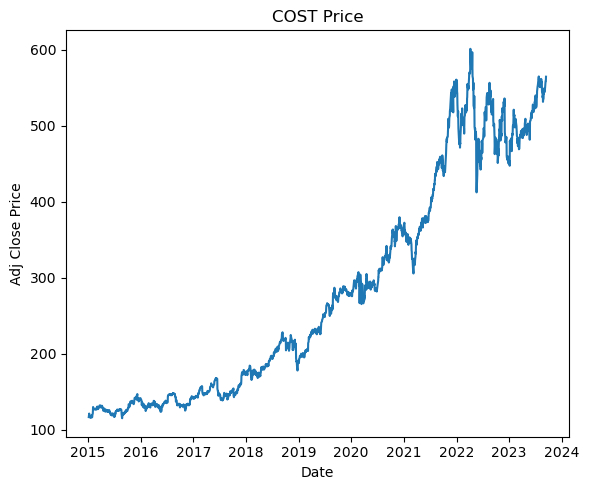

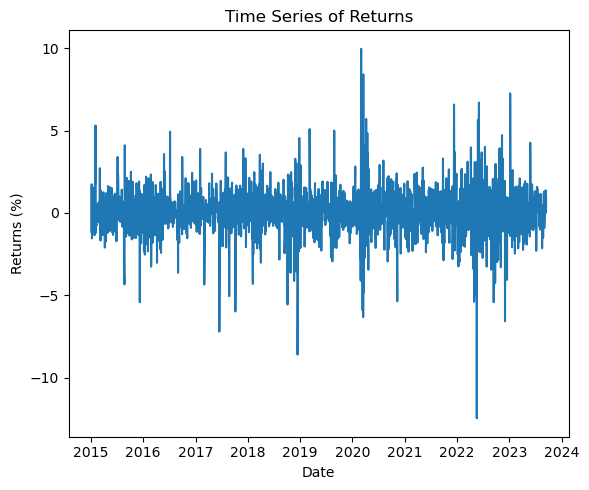

In [57]:
cost['Returns'] = cost['Adj Close'].pct_change() * 100
cost.dropna(subset=['Returns'], inplace=True)

return_ = cost['Returns']


# Convert the 'Date' column to datetime format
cost['Date'] = pd.to_datetime(cost['Date'])

# Plot the dataset with only the year shown on the x-axis
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(cost['Date'], cost['Adj Close'])

# Set the x-axis major locator to years and format labels to only show the year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set labels
plt.title('COST Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.tight_layout()
plt.show()

# Plot the returns data
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(cost['Date'], cost['Returns'])

# Set the x-axis major locator to years and format labels to only show the year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.title('Time Series of Returns')
plt.tight_layout()
plt.show()

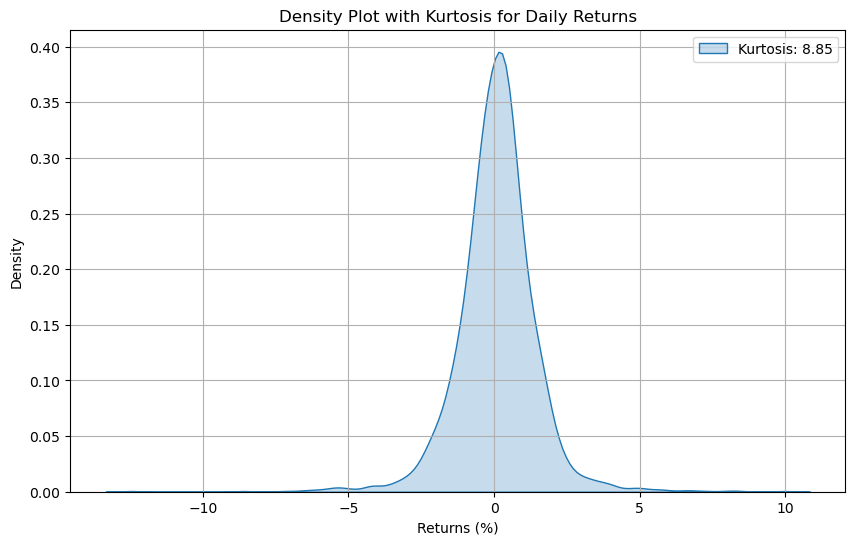

In [58]:
# Plotting the kurtosis
plt.figure(figsize=(10, 6))
sns.kdeplot(return_, fill=True, label=f"Kurtosis: {return_.kurtosis():.2f}")
plt.title("Density Plot with Kurtosis for Daily Returns")
plt.xlabel("Returns (%)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

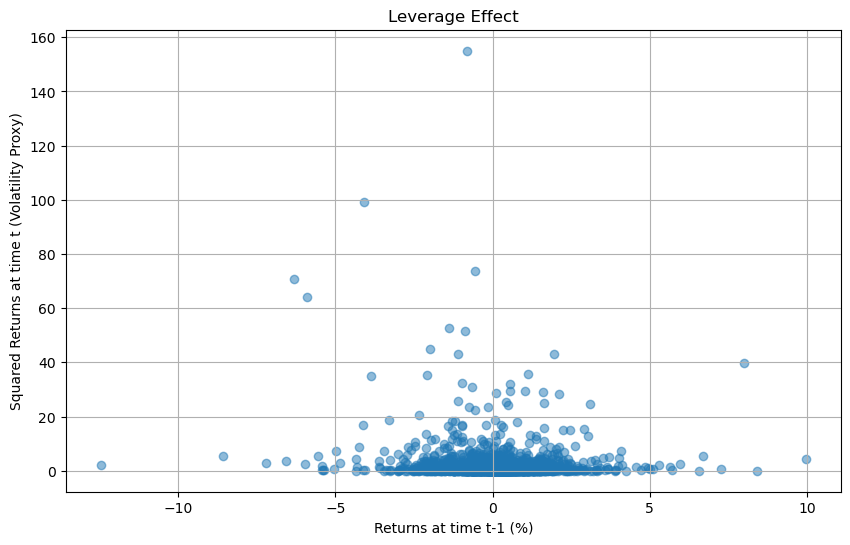

In [59]:
#Leverage effect plot
cost['Squared Returns'] = cost['Returns']**2

# Shift returns to represent returns at time t-1
cost['Lagged Returns'] = cost['Returns'].shift(1)

# Drop NaN values for the first row
cost.dropna(subset=['Lagged Returns'], inplace=True)

# Plotting the leverage effect with adjusted axes
plt.figure(figsize=(10, 6))
plt.scatter(cost['Lagged Returns'], cost['Squared Returns'], alpha=0.5)
plt.title("Leverage Effect")
plt.xlabel("Returns at time t-1 (%)")
plt.ylabel("Squared Returns at time t (Volatility Proxy)")
plt.grid(True)
plt.show()

## Benchmark Model – ARCH(1)

In [60]:
# # Fit the ARCH(1) Model
# model = arch_model(return_.dropna(), vol='Arch', p=1, q=0, dist='normal')
# results = model.fit(disp='off')

# # Forecasting and VaR/ES Calculation
# forecasts = results.forecast(start=1, horizon=22)
# variance_forecasts = forecasts.variance.dropna().iloc[-1]
# quantiles = [0.01, 0.05]
# z_values = [-results.conditional_volatility.iloc[-1] * np.percentile(cost['Returns'], q*100) for q in quantiles]
# normal_density = lambda x: (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
# horizons = [1, 5, 22]
# var_results = {}
# es_results = {}

# for horizon in horizons:
#     var_results[horizon] = {}
#     es_results[horizon] = {}
#     for quantile, z in zip(quantiles, z_values):
#         var_results[horizon][quantile] = -z * np.sqrt(variance_forecasts[horizon-1])
#         es_results[horizon][quantile] = -(z * normal_density(z) / (1 - quantile)) * np.sqrt(variance_forecasts[horizon-1])

# print(var_results)
# print(es_results)

In [61]:
model = arch_model(return_.dropna(), vol='Arch', p=1, q=0, dist='normal')
results = model.fit(disp='off')

results.summary

<bound method ARCHModelResult.summary of                       Constant Mean - ARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3723.91
Distribution:                  Normal   AIC:                           7453.83
Method:            Maximum Likelihood   BIC:                           7470.90
                                        No. Observations:                 2189
Date:                Wed, Nov 01 2023   Df Residuals:                     2188
Time:                        21:49:54   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1244  

## Proposed Models
### Model Building

#### Mean model

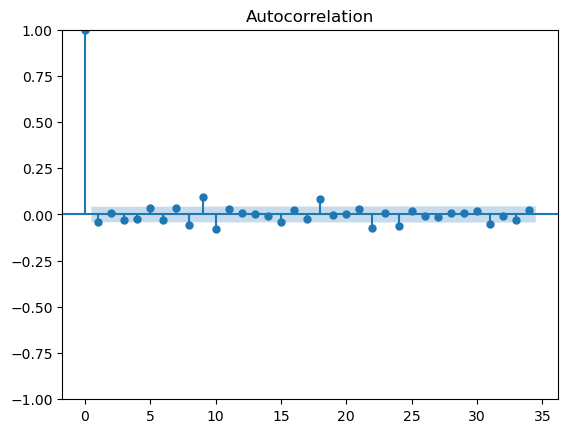

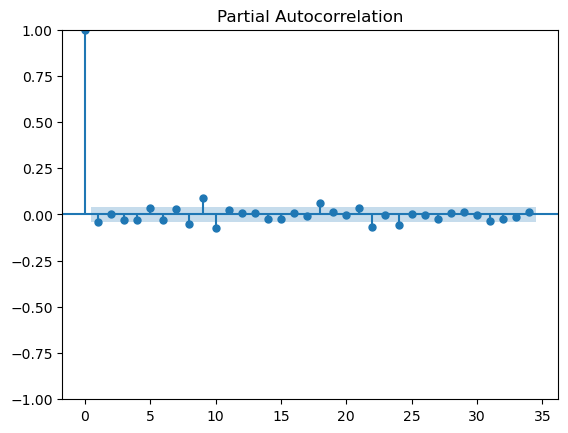

In [62]:
acfplot = sm.graphics.tsa.plot_acf(return_)
pacfplot = sm.graphics.tsa.plot_pacf(return_)

In [63]:
# Conduct Augmented Dickey-Fuller test
result = adfuller(return_)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

adf_statistic, p_value, critical_values

(-10.117530817129884,
 9.635865884149343e-18,
 {'1%': -3.4333740509447717,
  '5%': -2.8628759187993382,
  '10%': -2.567481176655697})

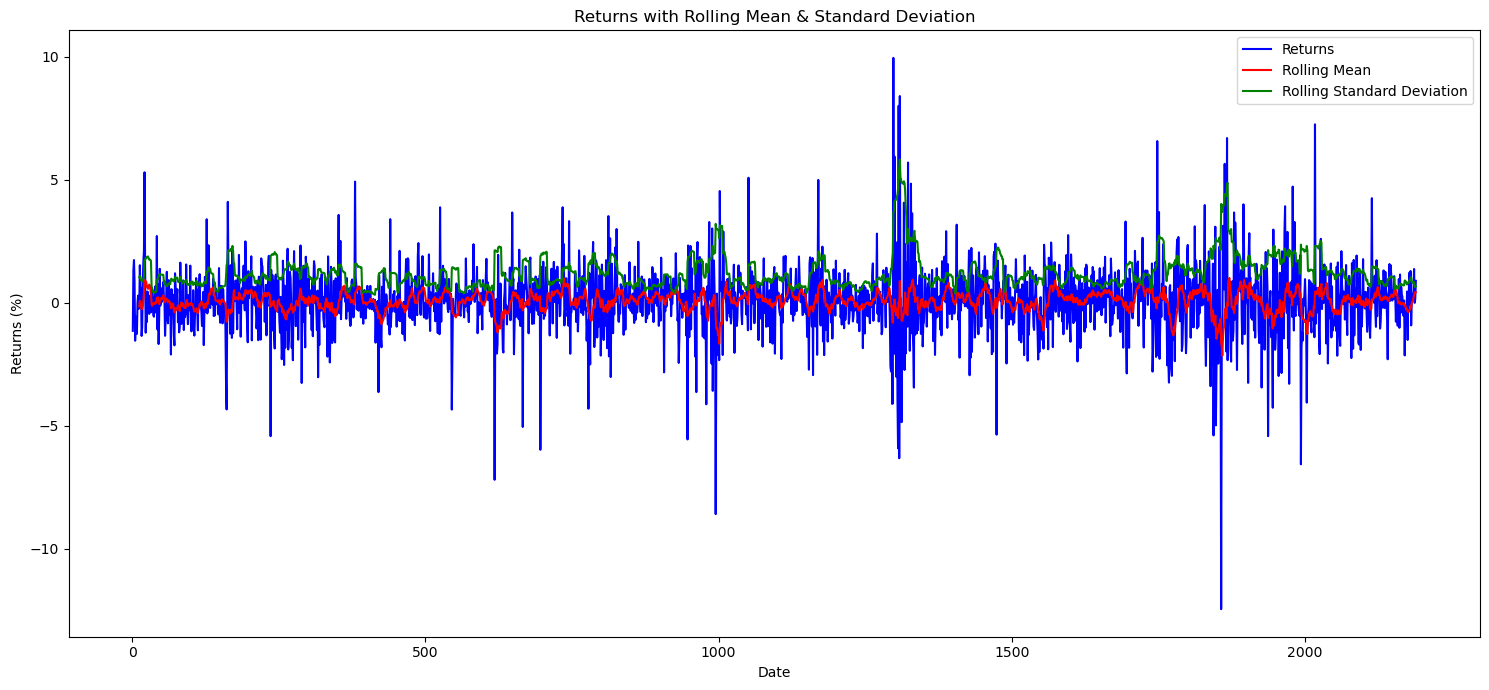

In [64]:
# Define the rolling mean and standard deviation
rolling_mean = return_.rolling(window=12).mean()
rolling_std = return_.rolling(window=12).std()

# Plot the time series with added x and y labels
plt.figure(figsize=(15, 7))
plt.plot(return_, label='Returns', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Standard Deviation', color='green')
plt.legend(loc='best')
plt.title('Returns with Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Returns (%)')

plt.tight_layout()
plt.show()

In [65]:
#AIC for AR models and constant mean

for p in range(6):
  result = ARIMA(return_, order=(p, 0, 0)).fit()
  print(result.aic)

#For ARMA(1,1)
result1 = ARIMA(return_, order=(1, 0, 1)).fit()
print(result1.aic)

#For ARMA(1,2)
result2 = ARIMA(return_, order=(1, 0, 2)).fit()
print(result2.aic)

#For ARMA(2,1)
result3 = ARIMA(return_, order=(2, 0, 1)).fit()
print(result3.aic)

7627.21991908445
7625.6323719106895
7627.573421552026
7627.413906219306
7627.627142826887
7627.295661767371
7627.405625992215
7629.3984505618355
7629.3990679710805


In [66]:
# Fit AR(1)
result_AR1 = ARIMA(return_, order=(1, 0, 0)).fit()
result_AR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                 2189
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3809.816
Date:                Wed, 01 Nov 2023   AIC                           7625.632
Time:                        21:49:56   BIC                           7642.706
Sample:                             0   HQIC                          7631.873
                               - 2189                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0810      0.029      2.773      0.006       0.024       0.138
ar.L1         -0.0405      0.014     -2.823      0.005      -0.069      -0.012
sigma2         1.9022      0.026     73.385      0.000       1.851       1.953
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6832.59
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Volatility Models

Regarding the average, we will adopt AR(1) approaches. To examine conditional variance, we'll be evaluating the
- ARCH(p) $p=1,5$
- GARCH(p,q) model  $p=1,5$ $q=1,5$
- EGARCH model
- GJR-GARCH model
The optimal model will be selected based on its AIC value.

In [67]:
for p in range(1,6):
  result_AR1_ARCH = arch_model(return_, mean='AR', lags=1, vol='GARCH', p=p, q=0).fit(disp="off")
  print(result_AR1_ARCH.aic)

7452.5070262037225
7424.617384143774
7375.221090019694
7375.237651440843
7340.021906811608


In [68]:
# Define max values for p and q
max_p = 6
max_q = 6

# Store AIC values in a dictionary with keys as (p, q)
aic_values = {}

for p in range(1, max_p + 1):
    for q in range(1, max_q + 1):
        # Define the GARCH model with AR(1) mean
        model = arch_model(return_, mean='AR', lags=1, vol='GARCH', p=p, q=q)

        # Fit the model
        model_fit = model.fit(disp='off')  # disp='off' will not print convergence messages

        # Get the AIC value
        aic = model_fit.aic

        # Store in the dictionary
        aic_values[(p, q)] = aic

        # Print the AIC value
        print(f"For AR(1)-GARCH({p},{q}), AIC = {aic:.2f}")

# Find the (p, q) with the lowest AIC
best_pq = min(aic_values, key=aic_values.get)
print(f"\nThe best AR(1)-GARCH(p,q) with the lowest AIC is: AR(1)-GARCH{best_pq}")

For AR(1)-GARCH(1,1), AIC = 7300.55
For AR(1)-GARCH(1,2), AIC = 7295.22
For AR(1)-GARCH(1,3), AIC = 7295.68
For AR(1)-GARCH(1,4), AIC = 7281.77
For AR(1)-GARCH(1,5), AIC = 7283.77
For AR(1)-GARCH(1,6), AIC = 7285.77
For AR(1)-GARCH(2,1), AIC = 7302.55
For AR(1)-GARCH(2,2), AIC = 7297.22
For AR(1)-GARCH(2,3), AIC = 7297.68
For AR(1)-GARCH(2,4), AIC = 7283.43
For AR(1)-GARCH(2,5), AIC = 7285.43
For AR(1)-GARCH(2,6), AIC = 7287.42
For AR(1)-GARCH(3,1), AIC = 7304.55
For AR(1)-GARCH(3,2), AIC = 7299.22
For AR(1)-GARCH(3,3), AIC = 7299.68
For AR(1)-GARCH(3,4), AIC = 7285.37
For AR(1)-GARCH(3,5), AIC = 7286.98
For AR(1)-GARCH(3,6), AIC = 7288.94
For AR(1)-GARCH(4,1), AIC = 7306.55
For AR(1)-GARCH(4,2), AIC = 7301.22
For AR(1)-GARCH(4,3), AIC = 7301.68
For AR(1)-GARCH(4,4), AIC = 7287.37
For AR(1)-GARCH(4,5), AIC = 7288.98
For AR(1)-GARCH(4,6), AIC = 7290.94
For AR(1)-GARCH(5,1), AIC = 7308.55
For AR(1)-GARCH(5,2), AIC = 7303.22
For AR(1)-GARCH(5,3), AIC = 7303.68
For AR(1)-GARCH(5,4), AIC = 

In [69]:
# Define max values for p and q
max_p = 6
max_q = 6

# Store AIC values in a dictionary with keys as (p, q)
aic_values = {}

for p in range(1, max_p + 1):
    for q in range(1, max_q + 1):
        # Define the GARCH model with AR(1) mean
        model = arch_model(return_, mean='AR', lags=1, vol='GARCH', p=p, q=q)

        # Fit the model
        model_fit = model.fit(disp='off')  # disp='off' will not print convergence messages

        # Get the AIC value
        aic = model_fit.aic

        # Store in the dictionary
        aic_values[(p, q)] = aic

# Find the (p, q) with the lowest AIC
best_pq = min(aic_values, key=aic_values.get)
best_aic = aic_values[best_pq]
print(f"The best AR(1)-GARCH(p,q) model is: AR(1)-GARCH{best_pq} with AIC = {best_aic:.4f}")

The best AR(1)-GARCH(p,q) model is: AR(1)-GARCH(1, 4) with AIC = 7281.7653


In [70]:
#Best GARCH model
result_AR1_GARCH14 = arch_model(return_, mean='AR', lags=1, vol='GARCH', p=1, q=4).fit(disp="off")
result_AR1_GARCH14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                Returns   R-squared:                      -0.001
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -3632.88
Distribution:                  Normal   AIC:                           7281.77
Method:            Maximum Likelihood   BIC:                           7327.29
                                        No. Observations:                 2188
Date:                Wed, Nov 01 2023   Df Residuals:                     2186
Time:                        21:49:58   Df Model:                            2
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.1114  2.846e-02      3.914  9.080e-05    [5.562e-02,  0.167]
Returns[1] 1.0424e-03  2.909e-02  3.583e-02      0.971 [-5.597e-02,5.806e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2156  9.399e-02      2.294  2.181e-02 [3.136e-02,  0.400]
alpha[1]       0.1841  6.317e-02      2.914  3.567e-03 [6.028e-02,  0.308]
beta[1]        0.3023      0.217      1.391      0.164   [ -0.124,  0.728]
beta[2]        0.0000      0.201      0.000      1.000   [ -0.395,  0.395]
beta[3]    2.6897e-14      0.120  2.251e-13      1.000   [ -0.234,  0.234]
beta[4]        0.4016      0.128      3.131  1.740e-03   [  0.150,  0.653]
==========================================================================

Covariance estimator: robust
"""

In [71]:
#Best EGARCH model
#Define the range for p, d, q
p_values = range(0, 3)  # Example range
d_values = range(0, 3)  # Example range
q_values = range(0, 3)  # Example range

best_aic = float('inf')  # Set initial AIC to a high value
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = arch_model(return_, mean='AR', lags=1, vol='EGARCH', p=p, o=d, q=q, dist='Normal')
                results = model.fit(disp='off')
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
            except:  # Some combinations might not converge or result in errors
                pass

print(f"Best EGARCH Order: {best_order} with AIC: {best_aic}")

Best EGARCH Order: (2, 1, 1) with AIC: 7248.485013363206


In [72]:
egarch211 = arch_model(return_, mean='AR', lags=1, vol='EGARCH', p=2, o=1, q=1, dist='Normal')
egarch211_fit = egarch211.fit( disp="off" )
print(egarch211_fit.summary())

                          AR - EGARCH Model Results                           
Dep. Variable:                Returns   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3617.24
Distribution:                  Normal   AIC:                           7248.49
Method:            Maximum Likelihood   BIC:                           7288.32
                                        No. Observations:                 2188
Date:                Wed, Nov 01 2023   Df Residuals:                     2186
Time:                        21:49:59   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0923  2.513e-02      3.674  2.386e-04 

In [73]:
#Best GJR-GARCH model
# Define the range for p, d, q
p_values = range(0, 3)  # Example range
d_values = range(0, 3)  # Example range
q_values = range(0, 3)  # Example range

best_aic = float('inf')  # Set initial AIC to a high value
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = arch_model(return_, mean='AR', lags=1, vol='GARCH', p=p, o=d, q=q, dist='Normal')
                results = model.fit(disp='off')
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
            except:  # Some combinations might not converge or result in errors
                pass

print(f"Best GJR-GARCH Order: {best_order} with AIC: {best_aic}")

Best GJR-GARCH Order: (0, 1, 2) with AIC: 7264.011022573555


In [74]:
gjr = arch_model(return_, mean='AR', lags=1, vol='GARCH', p=0, o=1, q=2, dist='Normal')
gjr_fit = gjr.fit( disp="off" )
print(gjr_fit.summary())

                         AR - GJR-GARCH Model Results                         
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3626.01
Distribution:                  Normal   AIC:                           7264.01
Method:            Maximum Likelihood   BIC:                           7298.16
                                        No. Observations:                 2188
Date:                Wed, Nov 01 2023   Df Residuals:                     2186
Time:                        21:50:00   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0866  2.663e-02      3.253  1.143e

Eliminate conditional volatility using the ARCH LM test

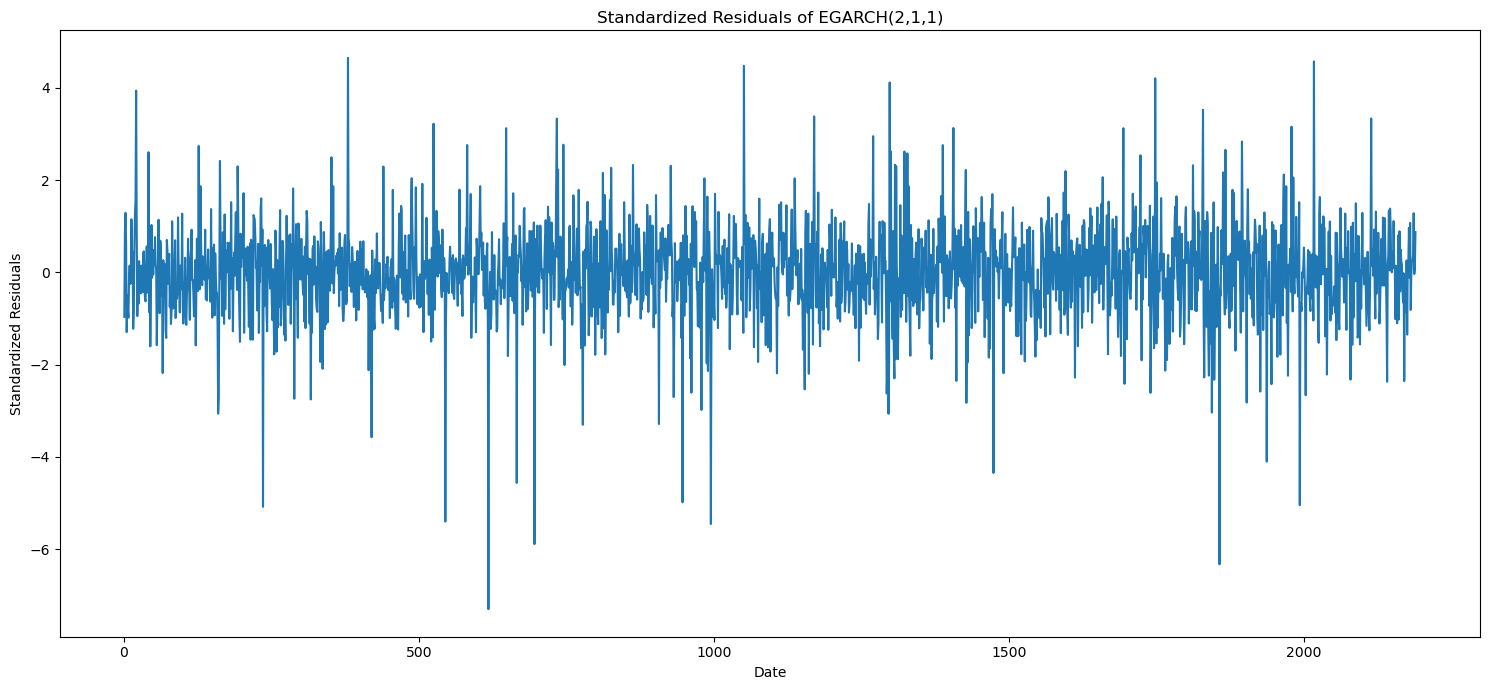

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 9.6079
P-value: 0.9986
Distributed: chi2(26)


In [75]:
# Fit the AR(1) model
model_AR1 = ARIMA(return_, order=(1,0,0))
result_AR1 = model_AR1.fit()

# Extract residuals from the AR(1) model
resid = result_AR1.resid

# Fit the EGARCH(2,1,1) model to the residuals
result_EGARCH211_resid = arch_model(resid, vol='EGARCH', p=2, o=1, q=1).fit(disp="off")

# Plotting the standardized residuals
plt.figure(figsize=(15, 7))
plt.plot(result_EGARCH211_resid.std_resid)
plt.title('Standardized Residuals of EGARCH(2,1,1)')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.tight_layout()
plt.show()

# Perform the ARCH LM test and display the result
arch_lm_test_result = result_EGARCH211_resid.arch_lm_test(standardized=True)
print(arch_lm_test_result)

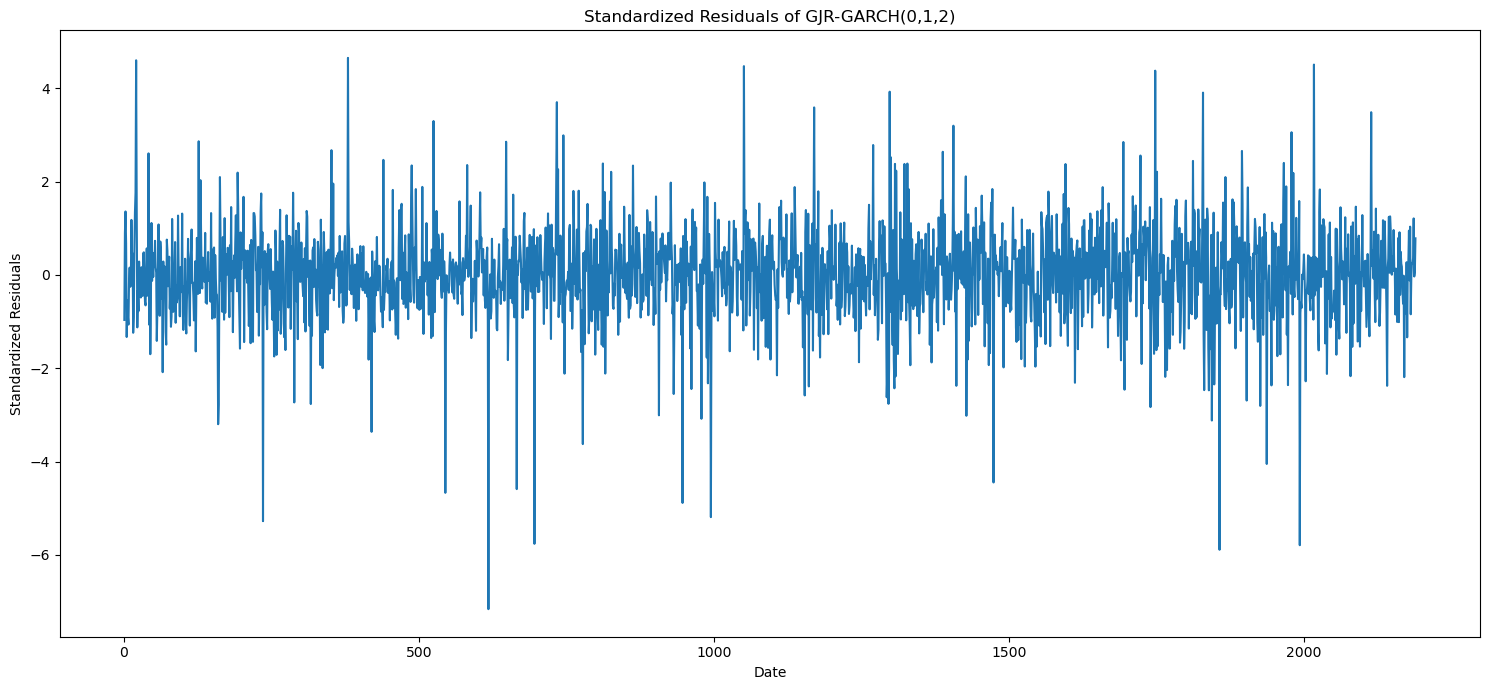

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 10.1092
P-value: 0.9978
Distributed: chi2(26)


In [76]:
# Fit the AR(1) model
model_AR1 = ARIMA(return_, order=(1,0,0))
result_AR1 = model_AR1.fit()

# Extract residuals from the AR(1) model
resid = result_AR1.resid

# Fit the GJR-GARCH(0,1,2) model to the residuals
result_GJR012_resid = arch_model(resid, vol='GARCH', p=0, o=1, q=2).fit(disp="off")

# Plotting the standardized residuals
plt.figure(figsize=(15, 7))
plt.plot(result_GJR012_resid.std_resid)
plt.title('Standardized Residuals of GJR-GARCH(0,1,2)')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.tight_layout()
plt.show()

# Perform the ARCH LM test and display the result
arch_lm_test_result = result_GJR012_resid.arch_lm_test(standardized=True)
print(arch_lm_test_result)

#### Choose an Error Distribution
Examine AIC using t errors

In [77]:
result_AR1_EGARCH211_t = arch_model(return_, mean='AR',lags=1, vol='EGARCH', p=2, o=1, q=1,dist='StudentsT').fit(disp="off")
result_AR1_EGARCH211_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AR - EGARCH Model Results                              
====================================================================================
Dep. Variable:                      Returns   R-squared:                      -0.001
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                           EGARCH   Log-Likelihood:               -3444.01
Distribution:      Standardized Student's t   AIC:                           6904.01
Method:                  Maximum Likelihood   BIC:                           6949.54
                                              No. Observations:                 2188
Date:                      Wed, Nov 01 2023   Df Residuals:                     2186
Time:                              21:50:00   Df Model:                            2
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.1029  2.159e-02      4.767  1.868e-06    [6.062e-02,  0.145]
Returns[1]     0.0113  2.112e-02      0.534      0.594 [-3.013e-02,5.267e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0235  7.627e-03      3.088  2.017e-03 [8.601e-03,3.850e-02]
alpha[1]       0.2457  5.042e-02      4.874  1.096e-06     [  0.147,  0.345]
alpha[2]      -0.1049  5.056e-02     -2.075  3.798e-02  [ -0.204,-5.822e-03]
gamma[1]      -0.0706  1.728e-02     -4.083  4.444e-05  [ -0.104,-3.669e-02]
beta[1]        0.9710  8.933e-03    108.704      0.000     [  0.953,  0.989]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0887      0.356     11.475  1.768e-30 [  3.390,  4.787]
========================================================================

Covariance estimator: robust
"""

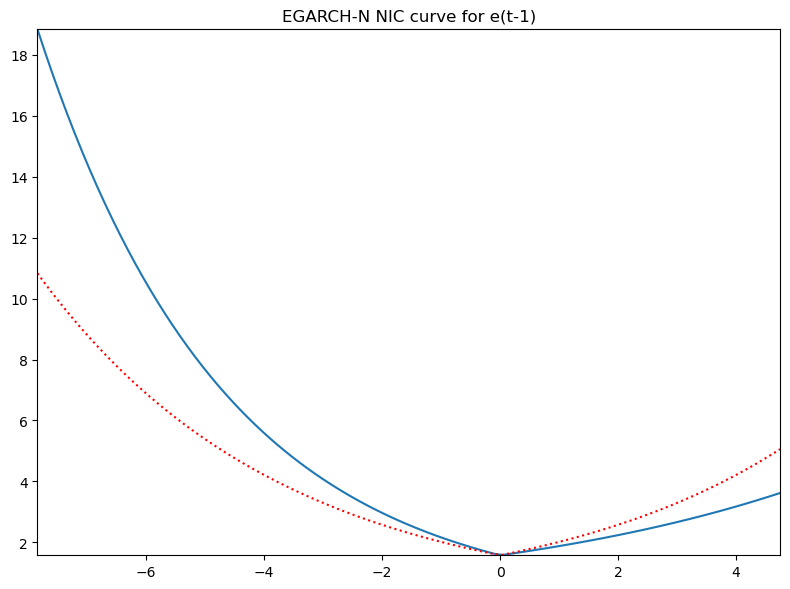

In [78]:
e_egarch = result_AR1_EGARCH211_t.std_resid
s_egarch = result_AR1_EGARCH211_t.conditional_volatility

alpha0 = result_AR1_EGARCH211_t.params['omega']
alpha1 = result_AR1_EGARCH211_t.params['alpha[1]']
gamma = result_AR1_EGARCH211_t.params['gamma[1]']
beta = result_AR1_EGARCH211_t.params['beta[1]']
e = result_AR1_EGARCH211_t.std_resid
a = e * result_AR1_EGARCH211_t.conditional_volatility
sig2 = a.var()
x = np.linspace(e.min(), e.max(), num=100)
s2 = lambda e: np.exp(alpha0 + alpha1 * (np.abs(e) - np.sqrt(2 / np.pi)) +
                      beta * np.log(sig2) + gamma * e)
s2_sym = lambda e: np.exp(alpha0 + alpha1 * (np.abs(e) - np.sqrt(2 / np.pi)) +
                          beta * np.log(sig2))
plt.figure(figsize=(8, 6))
plt.plot(x, s2(x))
plt.plot(x, s2_sym(x), ':r')
plt.axis([x[0], x[-1], s2(0), max(s2(x[0]), s2(x[-1]), s2_sym(x[0]), s2_sym(x[-1]))])
plt.title('EGARCH-N NIC curve for e(t-1)')
plt.tight_layout()
plt.show()

2. Investigate into QQ plot, and carry out Jarque Bera (JB) test on residuals

(3326.5061383317807, 0.0, -0.5861245413208815, 8.925708094477187)


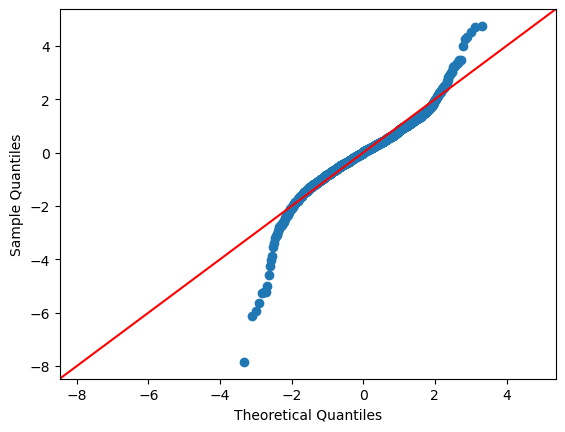

In [79]:
stdresid_normal = result_AR1_EGARCH211_t.std_resid.dropna()
qq_norm = sm.qqplot(stdresid_normal,line='45')
jb_norm = jarque_bera(stdresid_normal)
print(jb_norm)

(2.5049045600807727, 0.28580306763532526, -0.08105348240391454, 3.034603947293056)


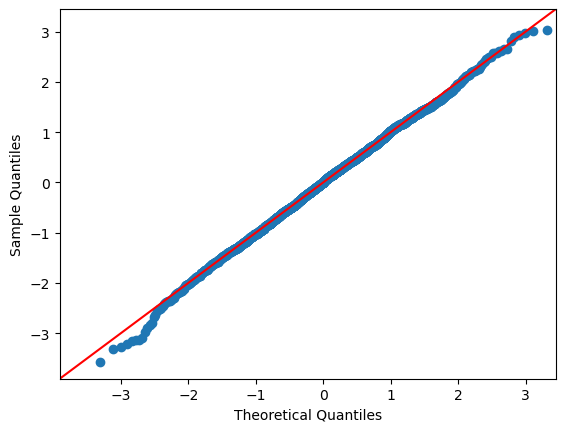

In [80]:
stdresid_t = result_AR1_EGARCH211_t.std_resid

df = result_AR1_EGARCH211_t.params['nu']
stdresid_t = result_AR1_EGARCH211_t.std_resid.dropna()
stdresid_t_unif = stats.t.cdf(np.sqrt(df / (df - 2)) * stdresid_t, df)
stdresid_t_trans = stats.norm.ppf(stdresid_t_unif)
qq_t = sm.qqplot(stdresid_t_trans,line='45')
jb_t = jarque_bera(stdresid_t_trans)
print(jb_t)

In [81]:
#GJR
gjr012 = arch_model(return_, mean='AR', lags=1, vol='GARCH', p=0, o=1, q=2, dist='StudentsT').fit(disp="off")
gjr012.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AR - GJR-GARCH Model Results                            
====================================================================================
Dep. Variable:                      Returns   R-squared:                      -0.001
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3453.90
Distribution:      Standardized Student's t   AIC:                           6921.79
Method:                  Maximum Likelihood   BIC:                           6961.63
                                              No. Observations:                 2188
Date:                      Wed, Nov 01 2023   Df Residuals:                     2186
Time:                              21:50:01   Df Model:                            2
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.1066  2.174e-02      4.902  9.477e-07    [6.396e-02,  0.149]
Returns[1] 9.0834e-03  2.169e-02      0.419      0.675 [-3.342e-02,5.159e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0769  2.599e-02      2.959  3.083e-03  [2.597e-02,  0.128]
gamma[1]       0.1426  3.349e-02      4.256  2.079e-05  [7.691e-02,  0.208]
beta[1]        0.6349      0.165      3.853  1.169e-04    [  0.312,  0.958]
beta[2]        0.2515      0.158      1.590      0.112 [-5.844e-02,  0.561]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0357      0.348     11.603  3.957e-31 [  3.354,  4.717]
========================================================================

Covariance estimator: robust
"""

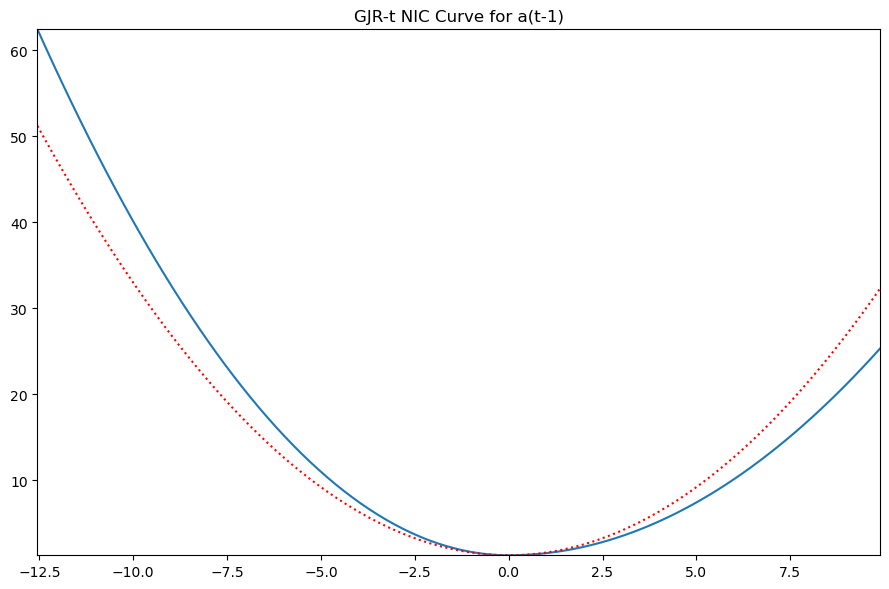

In [82]:
alpha0 = gjr012.params['omega']
#alpha1 = gjr012.params['alpha[1]']
gamma = gjr012.params['gamma[1]']
beta1 = gjr012.params['beta[1]']
e = gjr012.std_resid
a = e * gjr012.conditional_volatility
sig2 = a.var()
x = np.linspace(a.min(), a.max(), num=100)
s2 = lambda a: alpha0 + (alpha1 + gamma * (a < 0)) * (a ** 2) + beta1 * sig2 #def function
s2_sym = lambda a: alpha0 + (alpha1 + gamma / 2) * (a ** 2) + beta1 * sig2
plt.figure(figsize=(9, 6))
plt.plot(x, s2(x))
plt.plot(x, s2_sym(x), ':r')
plt.axis([x[0], x[-1], s2(0), max(s2(x[0]), s2(x[-1]), s2_sym(x[0]), s2_sym(x[-1]))]) #plug in a to the def function
plt.title('GJR-t NIC Curve for a(t-1)')
plt.tight_layout()
plt.show()

(2877.6912244136183, 0.0, -0.5250617633086556, 8.519276166527144)


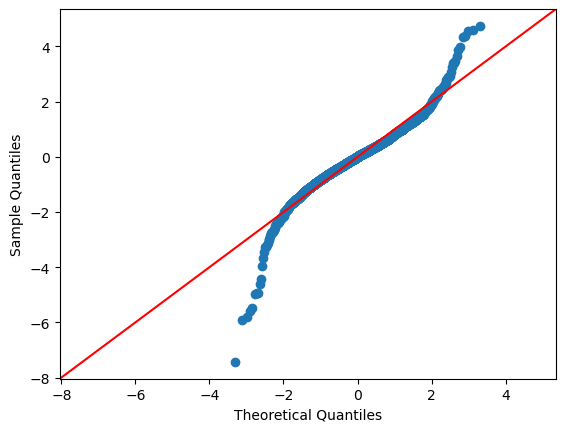

In [83]:
# Distribution
stdresid_normal = gjr012.std_resid.dropna()
qq_norm = sm.qqplot(stdresid_normal,line='45')
jb_norm = jarque_bera(stdresid_normal)
print(jb_norm)

(2.21838809891446, 0.32982467636104856, -0.07717657756838132, 3.0225483517688634)


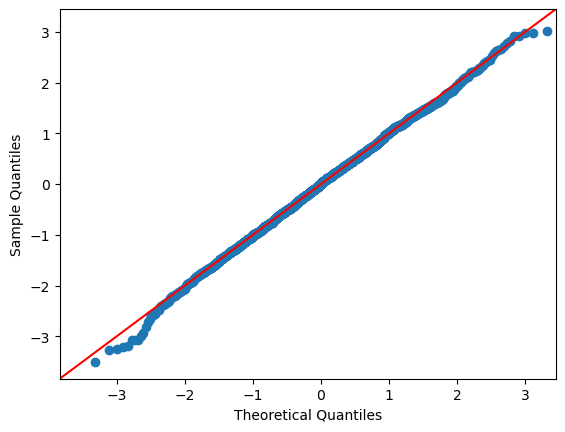

In [84]:
stdresid_t = gjr012.std_resid

df = gjr012.params['nu']
stdresid_t = gjr012.std_resid.dropna()
stdresid_t_unif = stats.t.cdf(np.sqrt(df / (df - 2)) * stdresid_t, df)
stdresid_t_trans = stats.norm.ppf(stdresid_t_unif)
qq_t = sm.qqplot(stdresid_t_trans,line='45')
jb_t = jarque_bera(stdresid_t_trans)
print(jb_t)

#### Forecast Validation


##### ARCH(1)

In [85]:
#Set number of windows (validation sample size)
n_window = 550
data1=cost.tail(n_window+1)

rng = 100 * (np.log(data1['High']) - np.log(data1['Low']))[1:]
rng[rng <= 0] = np.mean([0, np.min(rng[rng > 0])])
ovn = 100 * (np.log(data1['Open']) - np.log(data1['Close']).shift(1)).dropna()
proxy2 = 0.3607 * rng ** 2
proxy3 = 1.107 * proxy2 + 0.68 * ovn ** 2
proxy4 = np.exp(2 * np.log(rng) - 0.86 + 2 * 0.29 ** 2)

In [86]:
#Set number of windows (validation sample size)

fw = len(return_)-n_window-1 # First window

y_val = return_.tail(n_window) #Realisations in validation window
vprox1_val = (y_val-np.mean(y_val))**2.0

fc_mean_ARCH1 = [] #To store mean Forecasts ARCH(1)
fc_var_ARCH1 = [] #To store variance Forecasts ARCH(1)

for window in range(n_window):
    train = return_[:(fw+window+1)]
    res_ARCH1 = arch_model(train, vol='ARCH',p=1,q=0).fit(disp="off")
    fc_ARCH1 = res_ARCH1.forecast(horizon=1)
    fc_mean_ARCH1.append(fc_ARCH1.mean["h.1"][fw+window+1])
    fc_var_ARCH1.append(fc_ARCH1.variance["h.1"][fw+window+1])

rmse_mean_ARCH1 = np.sqrt(np.mean((y_val-fc_mean_ARCH1 )**2.0))
rmse_var_ARCH1 = np.sqrt(np.mean((vprox1_val-fc_var_ARCH1 )**2.0))

print('Mean forecasts')
print(rmse_mean_ARCH1)

print('Variance forecasts')
print(rmse_var_ARCH1)


#proxy 2,3,4
rmse2_var_ARCH1 = np.sqrt(np.mean((proxy2-fc_var_ARCH1 )**2.0))
rmse3_var_ARCH1 = np.sqrt(np.mean((proxy3-fc_var_ARCH1 )**2.0))
rmse4_var_ARCH1 = np.sqrt(np.mean((proxy4-fc_var_ARCH1 )**2.0))
print(rmse2_var_ARCH1)
print(rmse3_var_ARCH1)
print(rmse4_var_ARCH1)

Mean forecasts
1.6105864028796009
Variance forecasts
8.968129252413974
3.6802820106995866
4.536289739494278
4.1882322205207165


In [137]:
#h=5
B=10000

fw = len(return_)-n_window-5

fc5_mean_arch1 = [] #To store mean Forecasts AR(1)-ARCH(1)
fc5_var_arch1 = [] #To store variance Forecasts AR(1)-ARCH(1)

#Loop

for window in range(n_window):
    train = return_[:(fw+window+5)]
    arch1_h5 = arch_model(train, vol='ARCH',p=1,q=0).fit(disp="off")
    fc5_arch1 = arch1_h5.forecast(horizon=5, method='simulation', simulations=B)
    fc5_mean_arch1.append(fc5_arch1.mean["h.5"][fw+window+5])
    fc5_var_arch1.append(fc5_arch1.variance["h.5"][fw+window+5])


rmse_mean_arch1 = np.sqrt(np.mean((y_val-fc5_mean_arch1 )**2.0))
rmse_var_arch1 = np.sqrt(np.mean((vprox1_val-fc5_var_arch1 )**2.0))
print('Mean forecasts')
print(rmse_mean_arch1)
print('Variance forecasts')
print(rmse_var_arch1)

#proxy 2,3,4
rmse2_var_ARCH1h5 = np.sqrt(np.mean((proxy2-fc5_var_arch1 )**2.0))
rmse3_var_ARCH1h5 = np.sqrt(np.mean((proxy3-fc5_var_arch1 )**2.0))
rmse4_var_ARCH1h5 = np.sqrt(np.mean((proxy4-fc5_var_arch1 )**2.0))
print(rmse2_var_ARCH1h5)
print(rmse3_var_ARCH1h5)
print(rmse4_var_ARCH1h5)

Mean forecasts
1.6105864028796009
Variance forecasts
8.461511808411657
2.2204407200019114
3.520400795336861
3.1101736102862865


In [88]:
#h=22
B_22=40000

fw = len(return_)-n_window-22

fc22_mean_arch1 = [] #To store mean Forecasts AR(1)-ARCH(1)
fc22_var_arch1 = [] #To store variance Forecasts AR(1)-ARCH(1)

#Loop

for window in range(n_window):
    train = return_[:(fw+window+22)]
    arch1_h22 = arch_model(train, vol='ARCH',p=1,q=0).fit(disp="off")
    fc22_arch1 = arch1_h22.forecast(horizon=22, method='simulation', simulations=B_22)
    fc22_mean_arch1.append(fc22_arch1.mean["h.22"][fw+window+22])
    fc22_var_arch1.append(fc22_arch1.variance["h.22"][fw+window+22])


rmse_mean_arch1 = np.sqrt(np.mean((y_val-fc22_mean_arch1 )**2.0))
rmse_var_arch1 = np.sqrt(np.mean((vprox1_val-fc22_var_arch1 )**2.0))
print('Mean forecasts')
print(rmse_mean_arch1)
print('Variance forecasts')
print(rmse_var_arch1)

#proxy 2,3,4
rmse2_var_ARCH1h22 = np.sqrt(np.mean((proxy2-fc22_var_arch1 )**2.0))
rmse3_var_ARCH1h22 = np.sqrt(np.mean((proxy3-fc22_var_arch1 )**2.0))
rmse4_var_ARCH1h22 = np.sqrt(np.mean((proxy4-fc22_var_arch1 )**2.0))
print(rmse2_var_ARCH1h22)
print(rmse3_var_ARCH1h22)
print(rmse4_var_ARCH1h22)

Mean forecasts
1.6105864028796009
Variance forecasts
8.462351582878517
2.222899183367664
3.523038446628544
3.113725721732128


##### EGARCH(2,1,1)

In [89]:
fw = len(return_)-n_window-1 # First window

fc_mean_e211 = []
fc_var_e211 = []

#Loop

for window in range(n_window):
    train = return_[:(fw+window+1)]
    e211 = arch_model(train, mean='AR', lags=1, vol='EGARCH', p=2, o=1, q=1, dist='StudentsT').fit(disp="off")
    fc_e211 = e211.forecast(horizon=1)
    fc_mean_e211.append(fc_e211.mean["h.1"][fw+window+1])
    fc_var_e211.append(fc_e211.variance["h.1"][fw+window+1])


rmse_mean_e211 = np.sqrt(np.mean((y_val-fc_mean_e211 )**2.0))
rmse_var_e211 = np.sqrt(np.mean((vprox1_val-fc_var_e211 )**2.0))
print('Mean forecasts')
print(rmse_mean_e211)
print('Variance forecasts')
print(rmse_var_e211)

#proxy 2,3,4
rmse2_var_e211 = np.sqrt(np.mean((proxy2-fc_var_e211 )**2.0))
rmse3_var_e211 = np.sqrt(np.mean((proxy3-fc_var_e211 )**2.0))
rmse4_var_e211 = np.sqrt(np.mean((proxy4-fc_var_e211 )**2.0))
print(rmse2_var_e211)
print(rmse3_var_e211)
print(rmse4_var_e211)

Mean forecasts
1.6106386845486895
Variance forecasts
8.428835267495268
2.481361969461196
3.4907578828470864
3.0427433758212095


In [90]:
#h=5
B=10000

fw = len(return_)-n_window-5


fc5_mean_e211 = []
fc5_var_e211 = []

#Loop

for window in range(n_window):
    train = return_[:(fw+window+5)]
    e211_h5 = arch_model(train, mean='AR', lags=1, vol='EGARCH', p=2, o=1, q=1, dist='StudentsT').fit(disp="off")
    fc5_e211 = e211_h5.forecast(horizon=5, method='simulation', simulations=B)
    fc5_mean_e211.append(fc5_e211.mean["h.5"][fw+window+5])
    fc5_var_e211.append(fc5_e211.variance["h.5"][fw+window+5])


rmse_mean_e211h5 = np.sqrt(np.mean((y_val-fc5_mean_e211 )**2.0))
rmse_var_e211h5 = np.sqrt(np.mean((vprox1_val-fc5_var_e211 )**2.0))
print('Mean forecasts')
print(rmse_mean_e211h5)
print('Variance forecasts')
print(rmse_var_e211h5)


#proxy 2,3,4
rmse2_var_e211h5 = np.sqrt(np.mean((proxy2-fc5_var_e211 )**2.0))
rmse3_var_e211h5 = np.sqrt(np.mean((proxy3-fc5_var_e211 )**2.0))
rmse4_var_e211h5 = np.sqrt(np.mean((proxy4-fc5_var_e211 )**2.0))
print(rmse2_var_e211h5)
print(rmse3_var_e211h5)
print(rmse4_var_e211h5)

Mean forecasts
1.6100637685580146
Variance forecasts
333.32864406499635
333.2316312614778
333.2371525210152
333.2235287363819


In [91]:
#h=22
Boot=40000

fw = len(return_)-n_window-22

fc22_mean_e211 = []
fc22_var_e211 = []

#Loop
for window in range(n_window):
    train = return_[:(fw+window+22)]
    e211_h22 = arch_model(train, mean='AR', lags=1, vol='EGARCH', p=2, o=1, q=1, dist='StudentsT').fit(disp="off")
    fc22_e211 = e211_h22.forecast(horizon=22, method='simulation', simulations=Boot)
    fc22_mean_e211.append(fc22_e211.mean["h.22"][fw+window+22])
    fc22_var_e211.append(fc22_e211.variance["h.22"][fw+window+22])


rmse_mean_e211h22 = np.sqrt(np.mean((y_val-fc22_mean_e211 )**2.0))
rmse_var_e211h22 = np.sqrt(np.mean((vprox1_val-fc22_var_e211 )**2.0))
print('Mean forecasts')
print(rmse_mean_e211h22)
print('Variance forecasts')
print(rmse_var_e211h22)

#proxy 2,3,4
rmse2_var_e211h22 = np.sqrt(np.mean((proxy2-fc22_var_e211 )**2.0))
rmse3_var_e211h22 = np.sqrt(np.mean((proxy3-fc22_var_e211 )**2.0))
rmse4_var_e211h22 = np.sqrt(np.mean((proxy4-fc22_var_e211 )**2.0))
print(rmse2_var_e211h22)
print(rmse3_var_e211h22)
print(rmse4_var_e211h22)

Mean forecasts
1.6100637684212857
Variance forecasts
30375.006596740248
30375.00025524319
30374.99678483147
30374.994094019894


##### GJR (0,1,2)

In [92]:
fw = len(return_)-n_window-1 # First window

fc_mean_gjr = []
fc_var_gjr = []

#Loop

for window in range(n_window):
    train = return_[:(fw+window+1)]
    gjr = arch_model(train, mean='AR', lags=1, vol='GARCH', p=0, o=1, q=2, dist='StudentsT').fit(disp="off")
    fc_gjr = gjr.forecast(horizon=1)
    fc_mean_gjr.append(fc_gjr.mean["h.1"][fw+window+1])
    fc_var_gjr.append(fc_gjr.variance["h.1"][fw+window+1])


rmse_mean_gjr = np.sqrt(np.mean((y_val-fc_mean_gjr )**2.0))
rmse_var_gjr = np.sqrt(np.mean((vprox1_val-fc_var_gjr )**2.0))
print('Mean forecasts')
print(rmse_mean_gjr)
print('Variance forecasts')
print(rmse_var_gjr)

#proxy 2,3,4
rmse2_var_gjr = np.sqrt(np.mean((proxy2-fc_var_gjr )**2.0))
rmse3_var_gjr = np.sqrt(np.mean((proxy3-fc_var_gjr )**2.0))
rmse4_var_gjr = np.sqrt(np.mean((proxy3-fc_var_gjr )**2.0))
print(rmse2_var_gjr)
print(rmse3_var_gjr)
print(rmse4_var_gjr)

Mean forecasts
1.610554568474688
Variance forecasts
8.519622520659912
2.9032758499088285
3.743587982477556
3.743587982477556


In [93]:
#h=5
B=10000

fw = len(return_)-n_window-5

fc5_mean_gjr = []
fc5_var_gjr = []

#Loop

for window in range(n_window):
    train = return_[:(fw+window+5)]
    gjr_h5 = arch_model(train, mean='AR', lags=1, vol='GARCH', p=0, o=1, q=2, dist='StudentsT').fit(disp="off")
    fc5_gjr = gjr_h5.forecast(horizon=5, method='simulation', simulations=B)
    fc5_mean_gjr.append(fc5_gjr.mean["h.5"][fw+window+5])
    fc5_var_gjr.append(fc5_gjr.variance["h.5"][fw+window+5])


rmse_mean_gjrh5 = np.sqrt(np.mean((y_val-fc5_mean_gjr )**2.0))
rmse_var_gjrh5 = np.sqrt(np.mean((vprox1_val-fc5_var_gjr )**2.0))
print('Mean forecasts')
print(rmse_mean_gjrh5)
print('Variance forecasts')
print(rmse_var_gjrh5)


#proxy 2,3,4
rmse2_var_gjrh5 = np.sqrt(np.mean((proxy2-fc5_var_gjr )**2.0))
rmse3_var_gjrh5 = np.sqrt(np.mean((proxy3-fc5_var_gjr )**2.0))
rmse4_var_gjrh5 = np.sqrt(np.mean((proxy3-fc5_var_gjr )**2.0))
print(rmse2_var_gjrh5)
print(rmse3_var_gjrh5)
print(rmse4_var_gjrh5)

Mean forecasts
1.6100755439429273
Variance forecasts
8.432341591535678
2.528976534504044
3.5172299257923485
3.5172299257923485


In [94]:
#h=22
Boot=40000

fw = len(return_)-n_window-22

fc22_mean_gjr = []
fc22_var_gjr = []

#Loop
for window in range(n_window):
    train = return_[:(fw+window+22)]
    gjr_h22 = arch_model(train, mean='AR', lags=1, vol='GARCH', p=0, o=1, q=2, dist='StudentsT').fit(disp="off")
    fc22_gjr = gjr_h22.forecast(horizon=22, method='simulation', simulations=Boot)
    fc22_mean_gjr.append(fc22_gjr.mean["h.22"][fw+window+22])
    fc22_var_gjr.append(fc22_gjr.variance["h.22"][fw+window+22])


rmse_mean_gjrh22 = np.sqrt(np.mean((y_val-fc22_mean_gjr )**2.0))
rmse_var_gjrh22 = np.sqrt(np.mean((vprox1_val-fc22_var_gjr )**2.0))
print('Mean forecasts')
print(rmse_mean_gjrh22)
print('Variance forecasts')
print(rmse_var_gjrh22)

#proxy 2,3,4
rmse2_var_gjrh22 = np.sqrt(np.mean((proxy2-fc22_var_gjr )**2.0))
rmse3_var_gjrh22 = np.sqrt(np.mean((proxy3-fc22_var_gjr )**2.0))
rmse4_var_gjrh22 = np.sqrt(np.mean((proxy3-fc22_var_gjr )**2.0))
print(rmse2_var_gjrh22)
print(rmse3_var_gjrh22)
print(rmse4_var_gjrh22)

Mean forecasts
1.6100755438321372
Variance forecasts
8.394683317980672
2.0932809209214125
3.372985447769727
3.372985447769727


##### Mincer Zarnowitz (MZ) regression and Diebold Mariano (DM) test

In [95]:
##Compare mean forecasts between models

#h1
hypotheses = '(const = 0, x1 = 1)'

print('MZ regression Mean GJR-GARCH(0,1,2)') #H0: good forecast
x = sm.add_constant(fc_mean_gjr)
mzreg=sm.OLS(y_val,x).fit()
f_test_mean_gjr = mzreg.f_test(hypotheses)
print(f_test_mean_gjr)

print('Diebold Mariano Test') #H1: GJR is better than ARCH1
dm1=dm_test(y_val,fc_mean_gjr,fc_mean_ARCH1,one_sided=False)
print(dm1)

#h5
print('MZ regression Mean GJR-GARCH(0,1,2)')
x = sm.add_constant(fc5_mean_gjr)
mzreg=sm.OLS(y_val,x).fit()
f_test_mean_gjr5 = mzreg.f_test(hypotheses)
print(f_test_mean_gjr5)

print('Diebold Mariano Test')
dm5=dm_test(y_val,fc5_mean_gjr,fc5_mean_arch1,one_sided=False)
print(dm5)

#h22
print('MZ regression Mean GJR-GARCH(0,1,2)')
x = sm.add_constant(fc22_mean_gjr)
mzreg=sm.OLS(y_val,x).fit()
f_test_mean_gjr22 = mzreg.f_test(hypotheses)
print(f_test_mean_gjr22)

print('Diebold Mariano Test')
dm22=dm_test(y_val,fc22_mean_gjr,fc22_mean_arch1,one_sided=False)
print(dm22)

MZ regression Mean GJR-GARCH(0,1,2)
<F test: F=0.5474513802154872, p=0.5787381179742519, df_denom=548, df_num=2>
Diebold Mariano Test
(-0.022594289411678955, 0.98198210858033)
MZ regression Mean GJR-GARCH(0,1,2)
<F test: F=3.05504821874402, p=0.0479238414899952, df_denom=548, df_num=2>
Diebold Mariano Test
(-0.6945509289187121, 0.4876305902063989)
MZ regression Mean GJR-GARCH(0,1,2)
<F test: F=3.0550461843787136, p=0.04792393790963391, df_denom=548, df_num=2>
Diebold Mariano Test
(-0.6945510884956547, 0.48763049024884864)


In [96]:
##Compare mean forecasts between models

#h1
hypotheses = '(const = 0, x1 = 1)'

print('MZ regression Variance GJR-GARCH(0,1,2)')
x = sm.add_constant(fc_var_gjr)
mzreg=sm.OLS(vprox1_val,x).fit()
f_test_var_gjr = mzreg.f_test(hypotheses)
print(f_test_var_gjr)

print('Diebold Mariano Test')
vdm1=dm_test(vprox1_val,fc_var_gjr,fc_var_ARCH1,one_sided=False)
print(vdm1)

#h5
print('MZ regression Variance GJR-GARCH(0,1,2)')
x = sm.add_constant(fc5_var_gjr)
mzreg=sm.OLS(vprox1_val,x).fit()
f_test_var_gjr5 = mzreg.f_test(hypotheses)
print(f_test_var_gjr5)

print('Diebold Mariano Test')
vdm5=dm_test(vprox1_val,fc5_var_gjr,fc5_var_arch1,one_sided=False)
print(vdm5)

#h22
print('MZ regression Variance GJR-GARCH(0,1,2)')
x = sm.add_constant(fc22_var_gjr)
mzreg=sm.OLS(vprox1_val,x).fit()
f_test_var_gjr22 = mzreg.f_test(hypotheses)
print(f_test_var_gjr22)

print('Diebold Mariano Test')
vdm22=dm_test(vprox1_val,fc22_var_gjr,fc22_var_arch1,one_sided=False)
print(vdm22)

MZ regression Variance GJR-GARCH(0,1,2)
<F test: F=10.311615574009886, p=4.0172877364379107e-05, df_denom=548, df_num=2>
Diebold Mariano Test
(-1.5471789927402233, 0.12239631911589344)
MZ regression Variance GJR-GARCH(0,1,2)
<F test: F=4.646801622829802, p=0.009973350752711555, df_denom=548, df_num=2>
Diebold Mariano Test
(-0.2285485651956533, 0.819304910051511)
MZ regression Variance GJR-GARCH(0,1,2)
<F test: F=1.4535530701366166, p=0.2346380542173083, df_denom=548, df_num=2>
Diebold Mariano Test
(-1.632587053681961, 0.10312925691199326)


In [97]:
#ARCH 1

#h1
print('MZ regression Mean ARCH1')
hypotheses = '(const = 0, x1 = 1)'
x = sm.add_constant(fc_mean_ARCH1)
mzreg=sm.OLS(y_val,x).fit()
f_test_mean_ARCH1 = mzreg.f_test(hypotheses)
print(f_test_mean_ARCH1)

print('MZ regression Variance ARCH1')
hypotheses = '(const = 0, x1 = 1)'
x = sm.add_constant(fc_var_ARCH1)
mzreg=sm.OLS(vprox1_val,x).fit()
f_test_var_ARCH1 = mzreg.f_test(hypotheses)
print(f_test_var_ARCH1)


#h5
print('MZ regression Mean ARCH1')
hypotheses = '(const = 0, x1 = 1)'
x = sm.add_constant(fc5_mean_arch1)
mzreg=sm.OLS(y_val,x).fit()
f_test_mean5_ARCH1 = mzreg.f_test(hypotheses)
print(f_test_mean5_ARCH1)

print('MZ regression Variance ARCH1')
hypotheses = '(const = 0, x1 = 1)'
x = sm.add_constant(fc5_var_arch1)
mzreg=sm.OLS(vprox1_val,x).fit()
f_test_var5_ARCH1 = mzreg.f_test(hypotheses)
print(f_test_var5_ARCH1)



#h22
print('MZ regression Mean ARCH1')
hypotheses = '(const = 0, x1 = 1)'
x = sm.add_constant(fc22_mean_arch1)
mzreg=sm.OLS(y_val,x).fit()
f_test_mean22_ARCH1 = mzreg.f_test(hypotheses)
print(f_test_mean22_ARCH1)

print('MZ regression Variance ARCH1')
hypotheses = '(const = 0, x1 = 1)'
x = sm.add_constant(fc22_var_arch1)
mzreg=sm.OLS(vprox1_val,x).fit()
f_test_var22_ARCH1 = mzreg.f_test(hypotheses)
print(f_test_var22_ARCH1)

MZ regression Mean ARCH1
<F test: F=1.176359829679212, p=0.3091768577291505, df_denom=548, df_num=2>
MZ regression Variance ARCH1
<F test: F=36.14242564158418, p=1.8025657304542486e-15, df_denom=548, df_num=2>
MZ regression Mean ARCH1
<F test: F=1.176359829679212, p=0.3091768577291505, df_denom=548, df_num=2>
MZ regression Variance ARCH1
<F test: F=2.1680467437141373, p=0.11538114779065015, df_denom=548, df_num=2>
MZ regression Mean ARCH1
<F test: F=1.176359829679212, p=0.3091768577291505, df_denom=548, df_num=2>
MZ regression Variance ARCH1
<F test: F=2.41730084652747, p=0.09011216436724587, df_denom=548, df_num=2>


[DELETE?] Fit an AR(1)-GJRGARCH(1,1)-t model to COST data set


[DELETE?] #compare predicted conditional standard deviation values following positive and negative shocks of size 2
a = -2;
sigtm2 = alpha0 + alpha1 * a**2 + beta1 * sig2 + gamma * a**2
a = 2
sigta2 = alpha0 + alpha1 * a**2 + beta1 * sig2
print('\npredicted conditional variance values following positive and negative shocks of size 2 and ratio: {}, {}, {}'.format(round(sigtm2,4), round(sigta2,4), round(sigtm2/sigta2,4)))

[DELETE?] level of asymmetry
gm_n = egarch_fit.params['gamma[1]']
print((-4 * gm_n), np.exp(-4 * gm_n))

#### Value at Risk (VaR)

In [127]:
np.random.seed(0)
# Define the evaluation window and the entire window
Teval = len(return_) - 550
Tall = len(return_)

# Define the alpha values for 1% and 5% levels
alpha_values = [0.01, 0.05]

# Compute quantiles for the normal distribution
q_norm = {alpha: stats.norm.ppf(alpha) for alpha in alpha_values}

# Pre-allocate
Actual = np.zeros(Teval)
VaR_ARCH = {alpha: np.zeros(Teval) for alpha in alpha_values}
VaR_gjrGARCH = {alpha: np.zeros(Teval) for alpha in alpha_values}

for j in range(Teval-1):
    ret_train = return_[0:(Tall-Teval+j)]
    Actual[j] = return_[Tall-Teval+j+1]

    # ARCH(1) model
    arch = arch_model(ret_train, mean='AR', lags=1, vol='ARCH', p=1, dist='Normal')
    archfit = arch.fit(disp='off')
    archfc = archfit.forecast(horizon=1)
    Sigma_ARCH = np.sqrt(archfc.variance.values[-1, 0])

    for alpha in alpha_values:
        VaR_ARCH[alpha][j] = -(archfc.mean.values[-1, 0] + Sigma_ARCH * q_norm[alpha])

    # GJRGARCH(0,1,2) model
    gjrgarch = arch_model(ret_train, mean='AR', lags=1, vol='Garch', p=0, o=1, q=2, dist='StudentsT')
    gjrgarchfit = gjrgarch.fit(disp='off')
    gjrgarchfc = gjrgarchfit.forecast(horizon=1)
    Sigma_gjrGARCH = np.sqrt(gjrgarchfc.variance.values[-1, 0])
    nu = gjrgarchfit.params['nu']

    for alpha in alpha_values:
        q_t = np.sqrt((nu-2)/nu) * stats.t.ppf(alpha, df=nu)
        VaR_gjrGARCH[alpha][j] = -(gjrgarchfc.mean.values[-1, 0] + Sigma_gjrGARCH * q_t)

In [128]:
# Unconditional coverage test
def uctest(viol, a):
    n = len(viol)
    p = np.sum(viol) / n
    z = (p - a) / np.sqrt(a * (1 - a) / n)
    pval = 2 * stats.norm.sf(np.abs(z))
    return pval, p

# Independence test
def indtest(viol):
    n = len(viol)

    r5 = viol[1:]
    r51 = viol[:-1]
    i11 = r5*r51
    i01 = r5*(1-r51)
    i10 = (1-r5)*r51
    i00 = (1-r5)*(1-r51)

    t00 = np.sum(i00)
    t01 = np.sum(i01)
    t10 = np.sum(i10)
    t11 = np.sum(i11)
    p01 = t01/(t00+t01)
    p11 = t11/(t10+t11)
    p1 = (t01+t11)/n

    ll1 = t00 * np.log(1-p01) + (p01>0) * t01 * np.log(p01) + t10 * np.log(1-p11)
    if p11>0:
        ll1=ll1+t11*np.log(p11)

    ll0=(t10+t00)*np.log(1-p1)+(t01+t11)*np.log(p1)

    lrind=2*(ll1-ll0)
    pcc=1-stats.chi2.cdf(lrind,1)
    return pcc, lrind

# Dynamic quantile test
def dqtest(y,var,a,lag):
    n = len(y)
    hits = ((-y>var)*1)*(1-a)
    hits = (hits)*1+(-y<var)*(-a)
    q=2+lag

    if np.sum((-y>var)*1) > 0:
        ns = n - lag
        xmat = np.column_stack([np.ones((ns,1)), var[lag:n+1]])
        for k in range(1,lag+1):
            lk = lag-k
            xmat = np.column_stack([xmat, hits[lk:n-k]])

        hx = np.dot((hits[lag:n+1]), xmat)
        xtx = np.linalg.lstsq(np.matmul(xmat.T, xmat), np.eye(q), rcond = None)[0]
        dq = np.dot(np.dot(hx, xtx), hx.T)
        dq = dq/(a*(1-a))
        pdq = 1 - stats.chi2.cdf(dq,q)
    else:
        pdq = np.nan
        dq = np.nan
    return pdq, dq


# Accuracy checks for VaR
def check_var_fc(var_fc, r, p):
    viol = -r > var_fc
    n_viol = np.sum(viol)
    pval_uc, p_hat = uctest(viol, p)
    pval_ind = indtest(viol)[0]
    pval_dq = dqtest(r, var_fc, p, 4)[0]
    return [n_viol, p_hat, pval_uc, pval_ind, pval_dq]

In [129]:
# Check the accuracy of VaR forecasts for both models at both levels:
results_arch = {}
results_gjrgarch = {}

for alpha in alpha_values:
    results_arch[alpha] = check_var_fc(VaR_ARCH[alpha], Actual, alpha)
    results_gjrgarch[alpha] = check_var_fc(VaR_gjrGARCH[alpha], Actual, alpha)

# Display the results
for alpha in alpha_values:
    print(f"ARCH {alpha*100}% VaR:", results_arch[alpha])
    print(f"AR(1)-gjrGARCH(0,1,2) {alpha*100}% VaR:", results_gjrgarch[alpha])

ARCH 1.0% VaR: [31, 0.018913971934106162, 0.0002867742140232779, 0.2741018801689039, 0.010585974750408345]
AR(1)-gjrGARCH(0,1,2) 1.0% VaR: [21, 0.012812690665039659, 0.2524403089710089, 0.4601713719628493, 0.3711615252590429]
ARCH 5.0% VaR: [94, 0.05735204392922514, 0.17203763129785643, 0.5065018935821476, 0.1393344416628255]
AR(1)-gjrGARCH(0,1,2) 5.0% VaR: [103, 0.06284319707138498, 0.017046653587352193, 0.8282182237725596, 0.05265534114816539]


In [140]:
Tall = len(return_)
Teval = 550
alpha_values = [0.01, 0.05]  # Level of VaR (1% and 5%)
horizons = [5, 22]
B = 1000  # Number of bootstrap samples
q_norm = stats.norm.ppf(alpha_values)

# Function to fit and forecast using ARCH model
def forecast_arch(data, horizon, alpha):
    model = arch_model(data, mean='AR', lags=1, vol='ARCH', p=1, dist='Normal')
    fit = model.fit(disp='off')
    forecast = fit.forecast(horizon=horizon, method='simulation', simulations=B)
    return -np.quantile(forecast.simulations.values[-1, :, horizon-1], alpha)

# Function to fit and forecast using GJR-GARCH model
def forecast_gjrgarch(data, horizon, alpha):
    model = arch_model(data, mean='AR', lags=1, vol='Garch', p=0, o=1, q=2, dist='StudentsT')
    fit = model.fit(disp='off')
    forecast = fit.forecast(horizon=horizon, method='simulation', simulations=B)
    return -np.quantile(forecast.simulations.values[-1, :, horizon-1], alpha)

# Pre-allocation
VaR_prealloc = {
    'ARCH': {alpha: {h: np.zeros(Teval) for h in horizons} for alpha in alpha_values},
    'gjrGARCH': {alpha: {h: np.zeros(Teval) for h in horizons} for alpha in alpha_values}
}
Actual = np.zeros(Teval)

# Model fitting and forecasting loop
for j in range(Teval - max(horizons)):
    ret_train = return_[0:(Tall - Teval + j)]
    Actual[j] = return_[Tall - Teval + j + max(horizons)]

    for alpha in alpha_values:
        for horizon in horizons:
            VaR_prealloc['ARCH'][alpha][horizon][j] = forecast_arch(ret_train, horizon, alpha)
            VaR_prealloc['gjrGARCH'][alpha][horizon][j] = forecast_gjrgarch(ret_train, horizon, alpha)

In [141]:
# Display results for both ARCH and gjrGARCH models
for model in ['ARCH', 'gjrGARCH']:
    for alpha in alpha_values:
        for horizon in horizons:
            check_results = check_var_fc(VaR_prealloc[model][alpha][horizon], Actual, alpha)

            # Print header for each model, alpha, and horizon combination
            print(f"Results for Model: {model}, Alpha: {alpha*100}%, Horizon: {horizon} days")

            # Check_var_fc returns metrics in the mentioned order
            metrics = [
                'Number of Violations',
                'P-hat',
                'P-value (UC Test)',
                'P-value (Independence Test)',
                'P-value (DQ Test)'
            ]

            # Display each metric and its value
            for metric, value in zip(metrics, check_results):
                print(f"{metric}: {value:.4f}")

            # Print separator for clarity
            print('-'*50)

Results for Model: ARCH, Alpha: 1.0%, Horizon: 5 days
Number of Violations: 12.0000
P-hat: 0.0218
P-value (UC Test): 0.0053
P-value (Independence Test): 0.4639
P-value (DQ Test): 0.0210
--------------------------------------------------
Results for Model: ARCH, Alpha: 1.0%, Horizon: 22 days
Number of Violations: 9.0000
P-hat: 0.0164
P-value (UC Test): 0.1336
P-value (Independence Test): 0.5839
P-value (DQ Test): 0.0731
--------------------------------------------------
Results for Model: ARCH, Alpha: 5.0%, Horizon: 5 days
Number of Violations: 35.0000
P-hat: 0.0636
P-value (UC Test): 0.1423
P-value (Independence Test): 0.5990
P-value (DQ Test): 0.4321
--------------------------------------------------
Results for Model: ARCH, Alpha: 5.0%, Horizon: 22 days
Number of Violations: 36.0000
P-hat: 0.0655
P-value (UC Test): 0.0963
P-value (Independence Test): 0.2924
P-value (DQ Test): 0.2314
--------------------------------------------------
Results for Model: gjrGARCH, Alpha: 1.0%, Horizon: 

Using Pinball Loss

In [132]:
# Function to compute pbloss
def compute_pbloss(vaR, actual, alpha):
    q = -vaR[:len(actual)]
    return alpha * (actual - q) * (q < actual) + (1 - alpha) * (q - actual) * (q > actual)

# Initialize results dictionary
results = {}

# Compute predictive quantile loss for both models and alpha levels for 1-day horizon
for model_name, model_data in [("ARCH", VaR_ARCH), ("gjrGARCH", VaR_gjrGARCH)]:
    for alpha in alpha_values:
        vaR = model_data[alpha]
        result_key = f"pbloss_{model_name}_{int(alpha*100)}_1"
        results[result_key] = compute_pbloss(vaR, Actual, alpha)

# Display results
output = {}
for alpha in alpha_values:
    output[f"Sum of pbLoss for ARCH at {alpha*100}% VaR for 1 day"] = np.sum(results[f'pbloss_ARCH_{int(alpha*100)}_1'])
    output[f"Sum of pbLoss for gjrGARCH at {alpha*100}% VaR for 1 day"] = np.sum(results[f'pbloss_gjrGARCH_{int(alpha*100)}_1'])

print(output)

{'Sum of pbLoss for ARCH at 1.0% VaR for 1 day': 45.66440840483422, 'Sum of pbLoss for gjrGARCH at 1.0% VaR for 1 day': 43.878138241223326, 'Sum of pbLoss for ARCH at 5.0% VaR for 1 day': 110.05678989190594, 'Sum of pbLoss for gjrGARCH at 5.0% VaR for 1 day': 116.32217342026361}


In [133]:
# Function to compute Pinball Loss
def compute_pinball_loss(q_values, actual_values, alpha):
    return alpha * (actual_values - q_values) * (q_values < actual_values) + \
           (1 - alpha) * (q_values - actual_values) * (q_values > actual_values)

# Pre-allocation for Pinball Loss values
pbloss_values = {
    'ARCH': {alpha: {h: np.zeros(Teval-1) for h in horizons} for alpha in alpha_values},
    'gjrGARCH': {alpha: {h: np.zeros(Teval-1) for h in horizons} for alpha in alpha_values}
}

# Iterate over all combinations of model, alpha, and horizon
for model in ['ARCH', 'gjrGARCH']:
    for alpha in alpha_values:
        for horizon in horizons:
            q = -VaR_prealloc[model][alpha][horizon]
            pbloss = compute_pinball_loss(q, Actual, alpha)

            # Store results in pbloss_values dictionary
            pbloss_values[model][alpha][horizon] = pbloss

            # Display results for current combination
            print(f"Results for Model: {model}, Alpha: {alpha*100}%, Horizon: {horizon} days")
            print(f"Sum of Pinball Loss: {np.sum(pbloss)}")

            # If model is gjrGARCH, then conduct t-test with ARCH model and display p-value
            if model == 'gjrGARCH':
                pbloss_ARCH = pbloss_values['ARCH'][alpha][horizon]
                p_value = stats.ttest_ind(pbloss, pbloss_ARCH).pvalue
                print(f"P-value (t-test with ARCH model): {p_value:.4f}")

            print('-'*50)

Results for Model: ARCH, Alpha: 1.0%, Horizon: 5 days
Sum of Pinball Loss: 39.36145099543533
--------------------------------------------------
Results for Model: ARCH, Alpha: 1.0%, Horizon: 22 days
Sum of Pinball Loss: 40.71796575767156
--------------------------------------------------
Results for Model: ARCH, Alpha: 5.0%, Horizon: 5 days
Sum of Pinball Loss: 102.09494150636374
--------------------------------------------------
Results for Model: ARCH, Alpha: 5.0%, Horizon: 22 days
Sum of Pinball Loss: 101.81932094258963
--------------------------------------------------
Results for Model: gjrGARCH, Alpha: 1.0%, Horizon: 5 days
Sum of Pinball Loss: 39.19815358571089
P-value (t-test with ARCH model): 0.9907
--------------------------------------------------
Results for Model: gjrGARCH, Alpha: 1.0%, Horizon: 22 days
Sum of Pinball Loss: 40.772193551285866
P-value (t-test with ARCH model): 0.9971
--------------------------------------------------
Results for Model: gjrGARCH, Alpha: 5.0%

### Expected Shortfall

In [134]:
# Defining the necessary variables and parameters
Teval = 550  # Number of windows to use
Tall = len(return_)  # Total number of observations
alpha_values = [0.01, 0.05]  # Level of VaR (1% and 5%)
q_norm = stats.norm.ppf(alpha_values)  # Quantile of standard normal

# Function to calculate ES for t-distribution
def es_t(alpha, nu):
    qq = stats.t.ppf(alpha, df=nu)
    term1 = np.sqrt((nu - 2.0) / nu)
    term2 = (nu + qq**2.0) / (nu - 1.0)
    term3 = stats.t.pdf(qq, df=nu) / alpha
    es = term1 * term2 * term3
    return es

# Defining horizons
horizons = [1, 5, 22]

# Pre-allocate the arrays with the correct shape
Actual = np.zeros((len(horizons), Teval - max(horizons)))
VaR_ARCH = np.zeros((len(alpha_values), len(horizons), Teval - max(horizons)))
VaR_gjrGARCH = np.zeros((len(alpha_values), len(horizons), Teval - max(horizons)))
ES_ARCH = np.zeros((len(alpha_values), len(horizons), Teval - max(horizons)))
ES_gjrGARCH = np.zeros((len(alpha_values), len(horizons), Teval - max(horizons)))

B = 1000  # Number of bootstrap samples for simulation

# Adjusted loop
for h, horizon in enumerate(horizons):
    for j in range(Teval - max(horizons)):
        ret_train = return_.iloc[0:(Tall-Teval+j)]

        # Ensure the index doesn't exceed the length of the series
        if Tall-Teval+j+horizon-1 < len(return_):
            Actual[h, j] = return_.iloc[Tall-Teval+j+horizon-1]

        for a, alpha in enumerate(alpha_values):
            # ARCH(1) model
            arch = arch_model(ret_train, mean='Zero', vol='ARCH', p=1, dist='Normal')
            archfit = arch.fit(disp='off')

            # If horizon is 1, we don't use simulation
            if horizon == 1:
                archfc = archfit.forecast(horizon=horizon)
                Sigma_ARCH = np.sqrt(archfc.variance.values[-1, 0])
                VaR_ARCH[a, h, j] = -Sigma_ARCH * q_norm[a]
                ES_ARCH[a, h, j] = -Sigma_ARCH * stats.norm.pdf(q_norm[a]) / alpha
            else:
                archfc = archfit.forecast(horizon=horizon, method='simulation', simulations=B)
                VaR_ARCH[a, h, j] = -np.quantile(archfc.simulations.values[-1, :, horizon-1], alpha)
                simvals_ARCH = archfc.simulations.values[-1, :, horizon-1]
                ES_ARCH[a, h, j] = -np.mean(simvals_ARCH[simvals_ARCH <= -VaR_ARCH[a, h, j]])

            # AR(1)-gjrGARCH(0,1,2) model
            gjrGARCH = arch_model(ret_train, mean='AR', lags=1, vol='GARCH', p=0, o=1, q=2, dist='StudentsT')
            gjrGARCHfit = gjrGARCH.fit(disp='off')

            # If horizon is 1, we don't use simulation
            if horizon == 1:
                gjrGARCHfc = gjrGARCHfit.forecast(horizon=horizon)
                Sigma_gjrGARCH = np.sqrt(gjrGARCHfc.variance.values[-1, 0])
                nu = gjrGARCHfit.params['nu']
                q_t = np.sqrt((nu-2)/nu) * stats.t.ppf(alpha, df=nu)
                VaR_gjrGARCH[a, h, j] = -Sigma_gjrGARCH * q_t
                ES_gjrGARCH[a, h, j] = -Sigma_gjrGARCH * es_t(alpha, nu)
            else:
                gjrGARCHfc = gjrGARCHfit.forecast(horizon=horizon, method='simulation', simulations=B)
                VaR_gjrGARCH[a, h, j] = -np.quantile(gjrGARCHfc.simulations.values[-1, :, horizon-1], alpha)
                simvals_gjrGARCH = gjrGARCHfc.simulations.values[-1, :, horizon-1]
                ES_gjrGARCH[a, h, j] = -np.mean(simvals_gjrGARCH[simvals_gjrGARCH <= -VaR_gjrGARCH[a, h, j]])

In [135]:
# Printing the Expected Shortfall (ES) results
print("Expected Shortfall (ES) Results\n")
print("Model               | Horizon | Alpha | Expected Shortfall")
print("-------------------------------------------------------------")

for h, horizon in enumerate(horizons):
    for a, alpha in enumerate(alpha_values):
        print(f"ARCH(1)             | {horizon:7} | {alpha:5} | {ES_ARCH[a, h, -1]:.4f}")
        print(f"AR(1)-gjrGARCH(0,1,2)| {horizon:7} | {alpha:5} | {ES_gjrGARCH[a, h, -1]:.4f}")


Expected Shortfall (ES) Results

Model               | Horizon | Alpha | Expected Shortfall
-------------------------------------------------------------
ARCH(1)             |       1 |  0.01 | -3.1891
AR(1)-gjrGARCH(0,1,2)|       1 |  0.01 | -3.6842
ARCH(1)             |       1 |  0.05 | -2.4682
AR(1)-gjrGARCH(0,1,2)|       1 |  0.05 | -2.2663
ARCH(1)             |       5 |  0.01 | 3.8890
AR(1)-gjrGARCH(0,1,2)|       5 |  0.01 | 3.0451
ARCH(1)             |       5 |  0.05 | 2.8937
AR(1)-gjrGARCH(0,1,2)|       5 |  0.05 | 2.2913
ARCH(1)             |      22 |  0.01 | 4.1485
AR(1)-gjrGARCH(0,1,2)|      22 |  0.01 | 3.3205
ARCH(1)             |      22 |  0.05 | 2.9324
AR(1)-gjrGARCH(0,1,2)|      22 |  0.05 | 2.4363


:Fissler Ziegel Loss to compare the forecast between ARCH and GJRGARCH model

In [136]:
# Joint loss function
def fsscore(v,e,x,a):
    fs = ((x<=v)-a)*(v-x)+(1/a)*(1/1+np.exp(-e))*(x<=v)*(v-x)+(1/1+np.exp(-e))*(e-v)-np.log(1+np.exp(e))
    return fs

# Placeholder for results
results = []
max_horizon = max(horizons)

for h, horizon in enumerate(horizons):
    for a, alpha in enumerate(alpha_values):

        # Lists to store FZ scores over all j iterations for both models
        FZ_ARCH_list = []
        FZ_gjrGARCH_list = []

        for j in range(Teval - max_horizon):

            # Calculate FZ scores for ARCH and AR(1)-gjrGARCH models
            FZ_ARCH = fsscore(-ES_ARCH[a][h][j], -VaR_ARCH[a][h][j], Actual[h][j], alpha)
            FZ_gjrGARCH = fsscore(-ES_gjrGARCH[a][h][j], -VaR_gjrGARCH[a][h][j], Actual[h][j], alpha)

            FZ_ARCH_list.append(FZ_ARCH)
            FZ_gjrGARCH_list.append(FZ_gjrGARCH)

        # Compute the average FZ scores over all j iterations
        avg_FZ_ARCH = np.mean(FZ_ARCH_list)
        avg_FZ_gjrGARCH = np.mean(FZ_gjrGARCH_list)

        # Compute the p-value using the two sets of average scores
        p_value = stats.ttest_ind(FZ_ARCH_list, FZ_gjrGARCH_list).pvalue

        # Store the results
        result = {
            "Horizon": horizon,
            "Alpha": alpha,
            "Average FZ_ARCH": round(avg_FZ_ARCH, 4),
            "Average FZ_gjrGARCH": round(avg_FZ_gjrGARCH, 4),
            "p-value": round(p_value, 4)
        }
        results.append(result)

# Convert the results to a DataFrame for better visualization and display it
results

[{'Horizon': 1,
  'Alpha': 0.01,
  'Average FZ_ARCH': 76046651.9253,
  'Average FZ_gjrGARCH': 21011331.0195,
  'p-value': 0.4812},
 {'Horizon': 1,
  'Alpha': 0.05,
  'Average FZ_ARCH': 83824.8993,
  'Average FZ_gjrGARCH': 5593.5763,
  'p-value': 0.3399},
 {'Horizon': 5,
  'Alpha': 0.01,
  'Average FZ_ARCH': 100.1,
  'Average FZ_gjrGARCH': 34360.3786,
  'p-value': 0.1165},
 {'Horizon': 5,
  'Alpha': 0.05,
  'Average FZ_ARCH': 16.4767,
  'Average FZ_gjrGARCH': 45.0034,
  'p-value': 0.0357},
 {'Horizon': 22,
  'Alpha': 0.01,
  'Average FZ_ARCH': 83.1499,
  'Average FZ_gjrGARCH': 229.5314,
  'p-value': 0.015},
 {'Horizon': 22,
  'Alpha': 0.05,
  'Average FZ_ARCH': 16.9149,
  'Average FZ_gjrGARCH': 18.0473,
  'p-value': 0.8325}]